# Analysis of the UK Referendum petition

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob
import io
import json

# sns.set(context='talk')
plt.style.use(['bmh', 'seaborn-talk'])

In [2]:
!rsync -vaz 'raspberrypi.local:petition-stats/data-*.json' .

data_files = glob.iglob('data*.json')
OFFSET = 2093225 - 1972043

dfs = []

for filename in data_files:
    with open(filename) as infile:
        data = json.load(infile)
        stats = data['data']['attributes']['signatures_by_constituency']
        s = io.StringIO()
        json.dump(stats, s)
        s.seek(0)
        df = pd.read_json(s)
        n_constituencies = len(df)
        av_correction_factor = OFFSET // n_constituencies
        df['corrected_signature_count'] = df['signature_count'] + av_correction_factor
        
        timestamp = int(filename.split('-')[-1].split('.')[0])
        df['timestamp'] = timestamp
        dfs.append(df)
df = pd.concat(dfs)

df['time'] = pd.to_datetime(df['timestamp'] * 1E9)
df = df.set_index('time').tz_localize('UTC').tz_convert('Europe/London')

receiving file list ... done
data-1466941666.json
data-1466941727.json
data-1466941789.json
data-1466941850.json
data-1466941910.json
data-1466941973.json
data-1466942035.json
data-1466942096.json
data-1466942158.json
data-1466942218.json
data-1466942280.json
data-1466942341.json
data-1466942403.json
data-1466942463.json
data-1466942525.json
data-1466942586.json
data-1466942647.json
data-1466942710.json
data-1466942772.json
data-1466942833.json
data-1466942895.json
data-1466942956.json
data-1466943017.json
data-1466943078.json
data-1466943140.json
data-1466943201.json
data-1466943262.json
data-1466943323.json
data-1466943384.json
data-1466943447.json
data-1466943509.json
data-1466943570.json
data-1466943631.json
data-1466943693.json
data-1466943754.json
data-1466943815.json
data-1466943878.json
data-1466943940.json
data-1466944001.json
data-1466944063.json
data-1466944123.json
data-1466944185.json
data-1466944245.json
data-1466944307.json
data-1466944368.json
data-1466944428.json
data-

[(3000000, 3200000)]

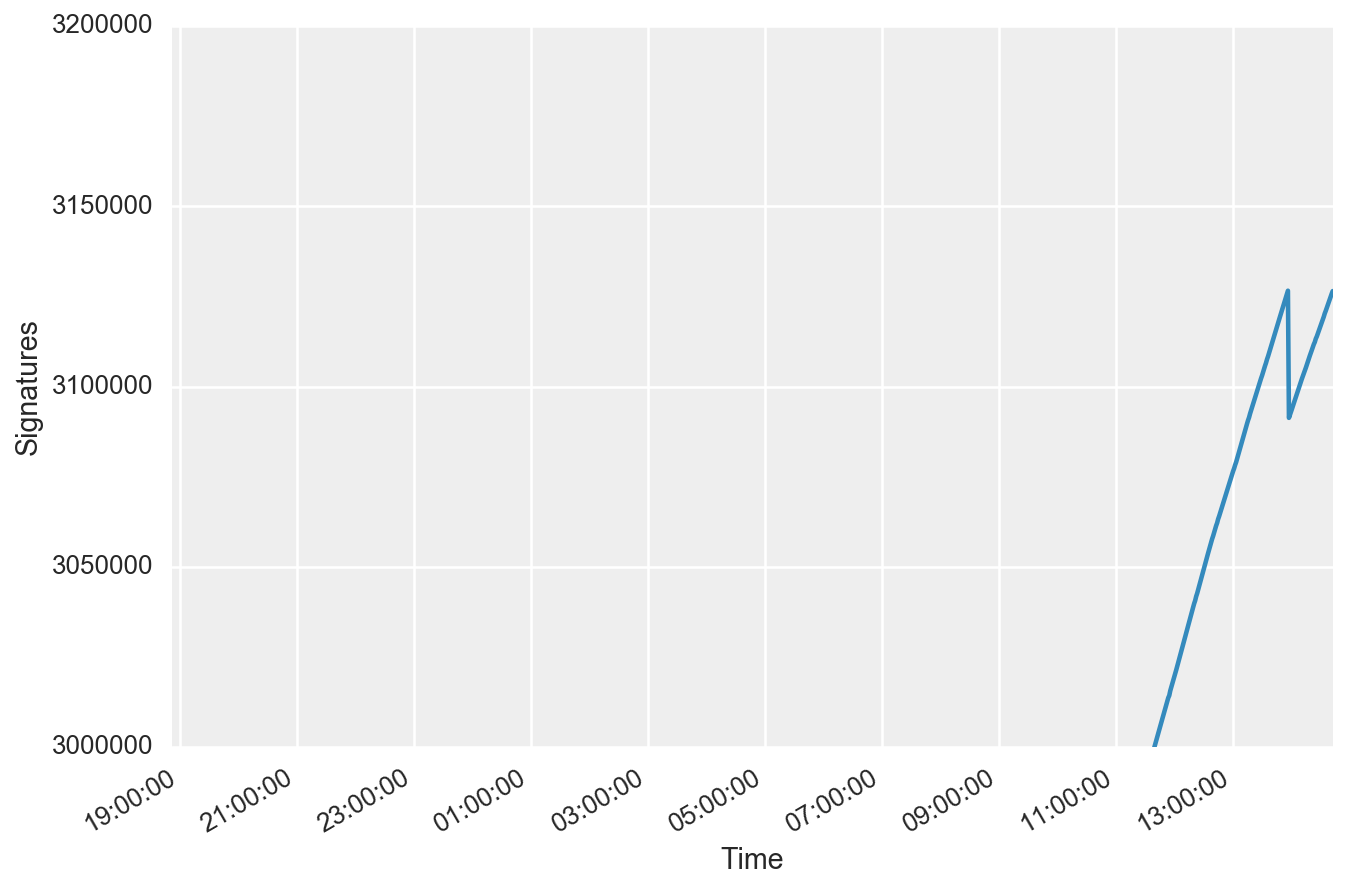

In [20]:
g = df.groupby(level=0)['corrected_signature_count'].sum()
ax = g.plot(x='index')
ax.set(xlabel='Time', ylabel='Signatures')
ax.set(ylim=(3000000, 3200000))

In [4]:
sig_count = df.groupby('timestamp').sum()['corrected_signature_count']

In [5]:
unique_timestamps = np.sort(df['timestamp'].unique())
last_entry = df[df.timestamp == unique_timestamps.max()]

[<matplotlib.text.Text at 0x11a532240>, <matplotlib.text.Text at 0x11a521dd8>]

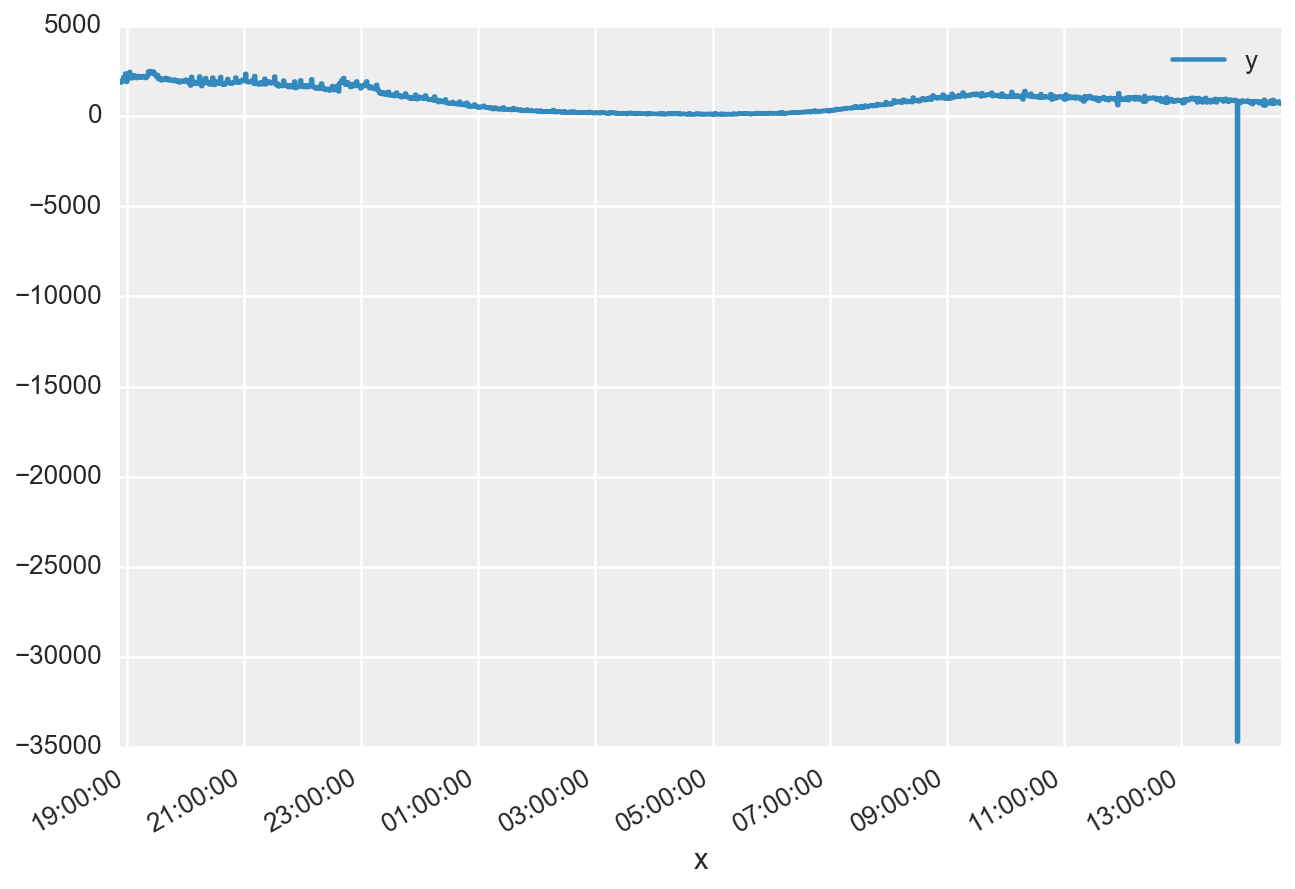

In [26]:
dt = np.diff(unique_timestamps)
rate = np.diff(sig_count) * 60. / dt
rate_df = pd.DataFrame({'x': g.index[1:], 'y': rate}).set_index('x')
rate_df.plot(y='y', drawstyle='steps-post')
ax.set(xlabel='Time', ylabel='Signatures per minute')

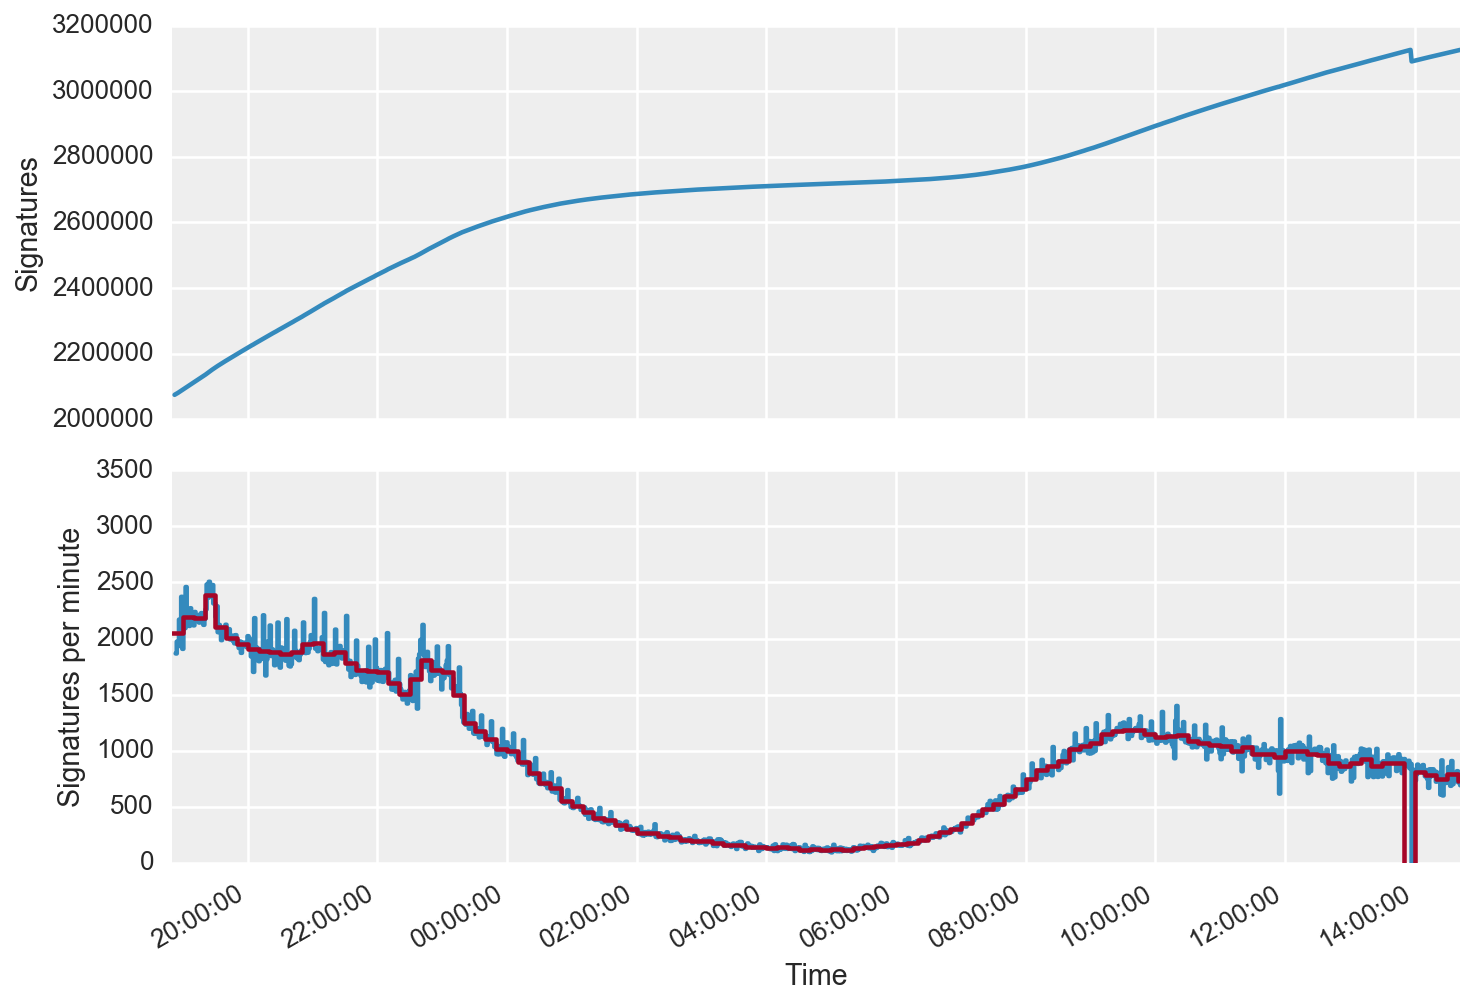

In [31]:
fig, axes = plt.subplots(2, 1, sharex=True)
g.plot(x='index', ax=axes[0])
rate_df.plot(y='y', ax=axes[1], legend=False, drawstyle='steps-post')
rate_df.resample('10T').mean().plot(y='y', ax=axes[1], legend=False, drawstyle='steps-post')
axes[0].set(ylabel='Signatures')
axes[1].set(xlabel='Time', ylabel='Signatures per minute', ylim=(max(rate_df.y.min(), 0), rate_df.y.max() + 1000))
fig.tight_layout()
fig.savefig('summary.png')

In [8]:
highest_10 = last_entry.sort_values(by='corrected_signature_count', ascending=False).head(10)
lowest_10 = last_entry.sort_values(by='corrected_signature_count', ascending=True).head(10)

In [9]:
wm_constituencies = {
    'Aldridge-Brownhills',
    'Birmingham, Edgbaston',
    'Birmingham, Erdington',
    'Birmingham, Hall Green',
    'Birmingham, Hodge Hill',
    'Birmingham, Ladywood',
    'Birmingham, Northfield',
    'Birmingham, Perry Barr',
    'Birmingham, Selly Oak',
    'Birmingham, Yardley',
    'Coventry North East',
    'Coventry North West',
    'Coventry South',
    'Dudley North',
    'Dudley South',
    'Halesowen and Rowley Regis',
    'Meriden',
    'Solihull',
    'Stourbridge',
    'Sutton Coldfield',
    'Walsall North',
    'Walsall South',
    'Warley',
    'West Bromwich East',
    'West Bromwich West',
    'Wolverhampton North East',
    'Wolverhampton South East',
    'Wolverhampton South West',
    }

In [10]:
def plot_group(data, subplots_kw=None):
    ts = df[df['ons_code'].isin(data['ons_code'].values)]
    
    subplots_kw = subplots_kw if subplots_kw is not None else {}
    fig, axis = plt.subplots(**subplots_kw)
    for name, group in ts.groupby('name'):
        group['corrected_signature_count'].plot(ax=axis, label=name)
    axis.set(xlabel='Time', ylabel='Signatures')
    axis.legend(loc='best')

In [32]:
wm = df[df['name'].isin(wm_constituencies)]
assert len(wm.name.unique()) == len(wm_constituencies)

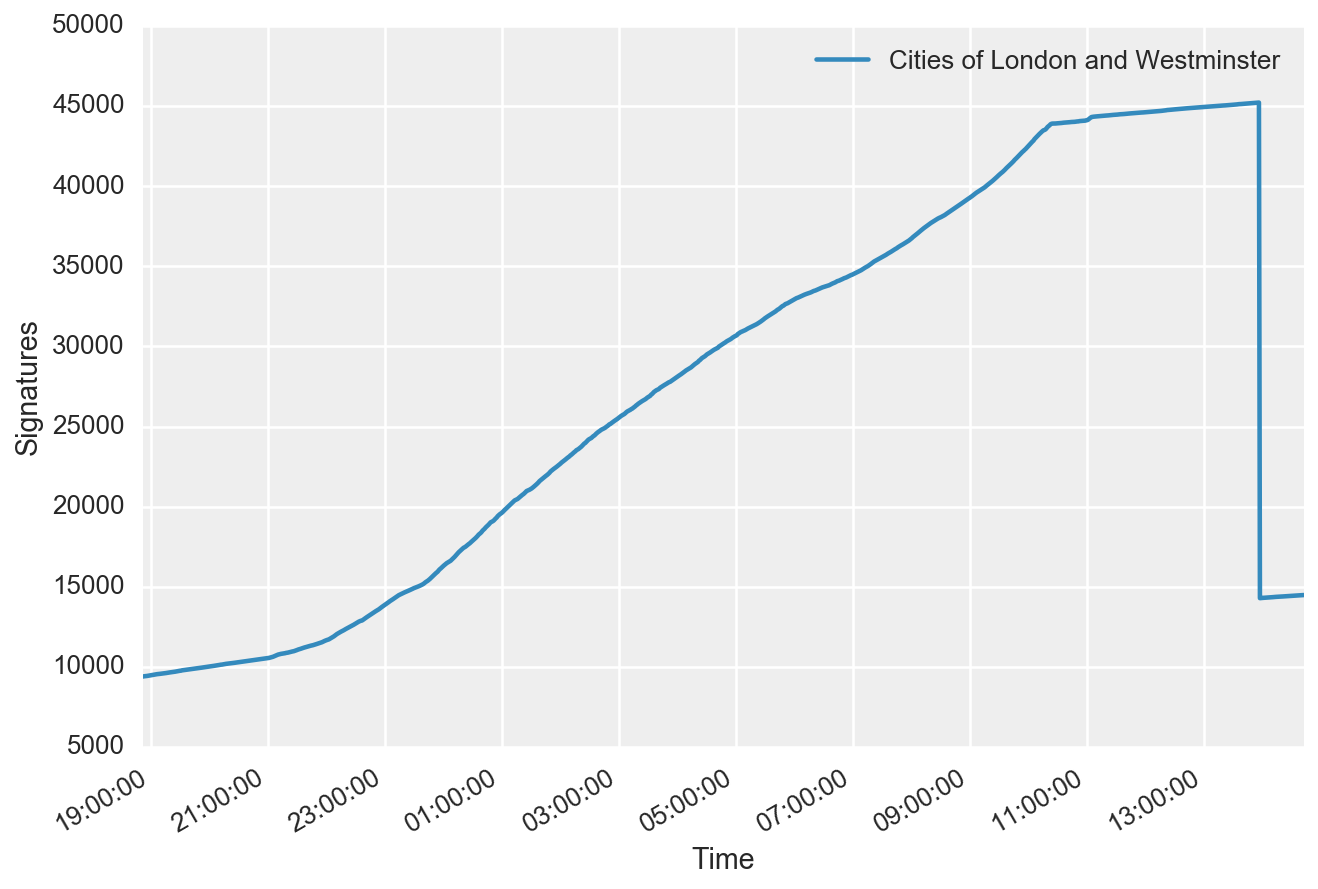

In [33]:
plot_group(df[df.name == 'Cities of London and Westminster'])

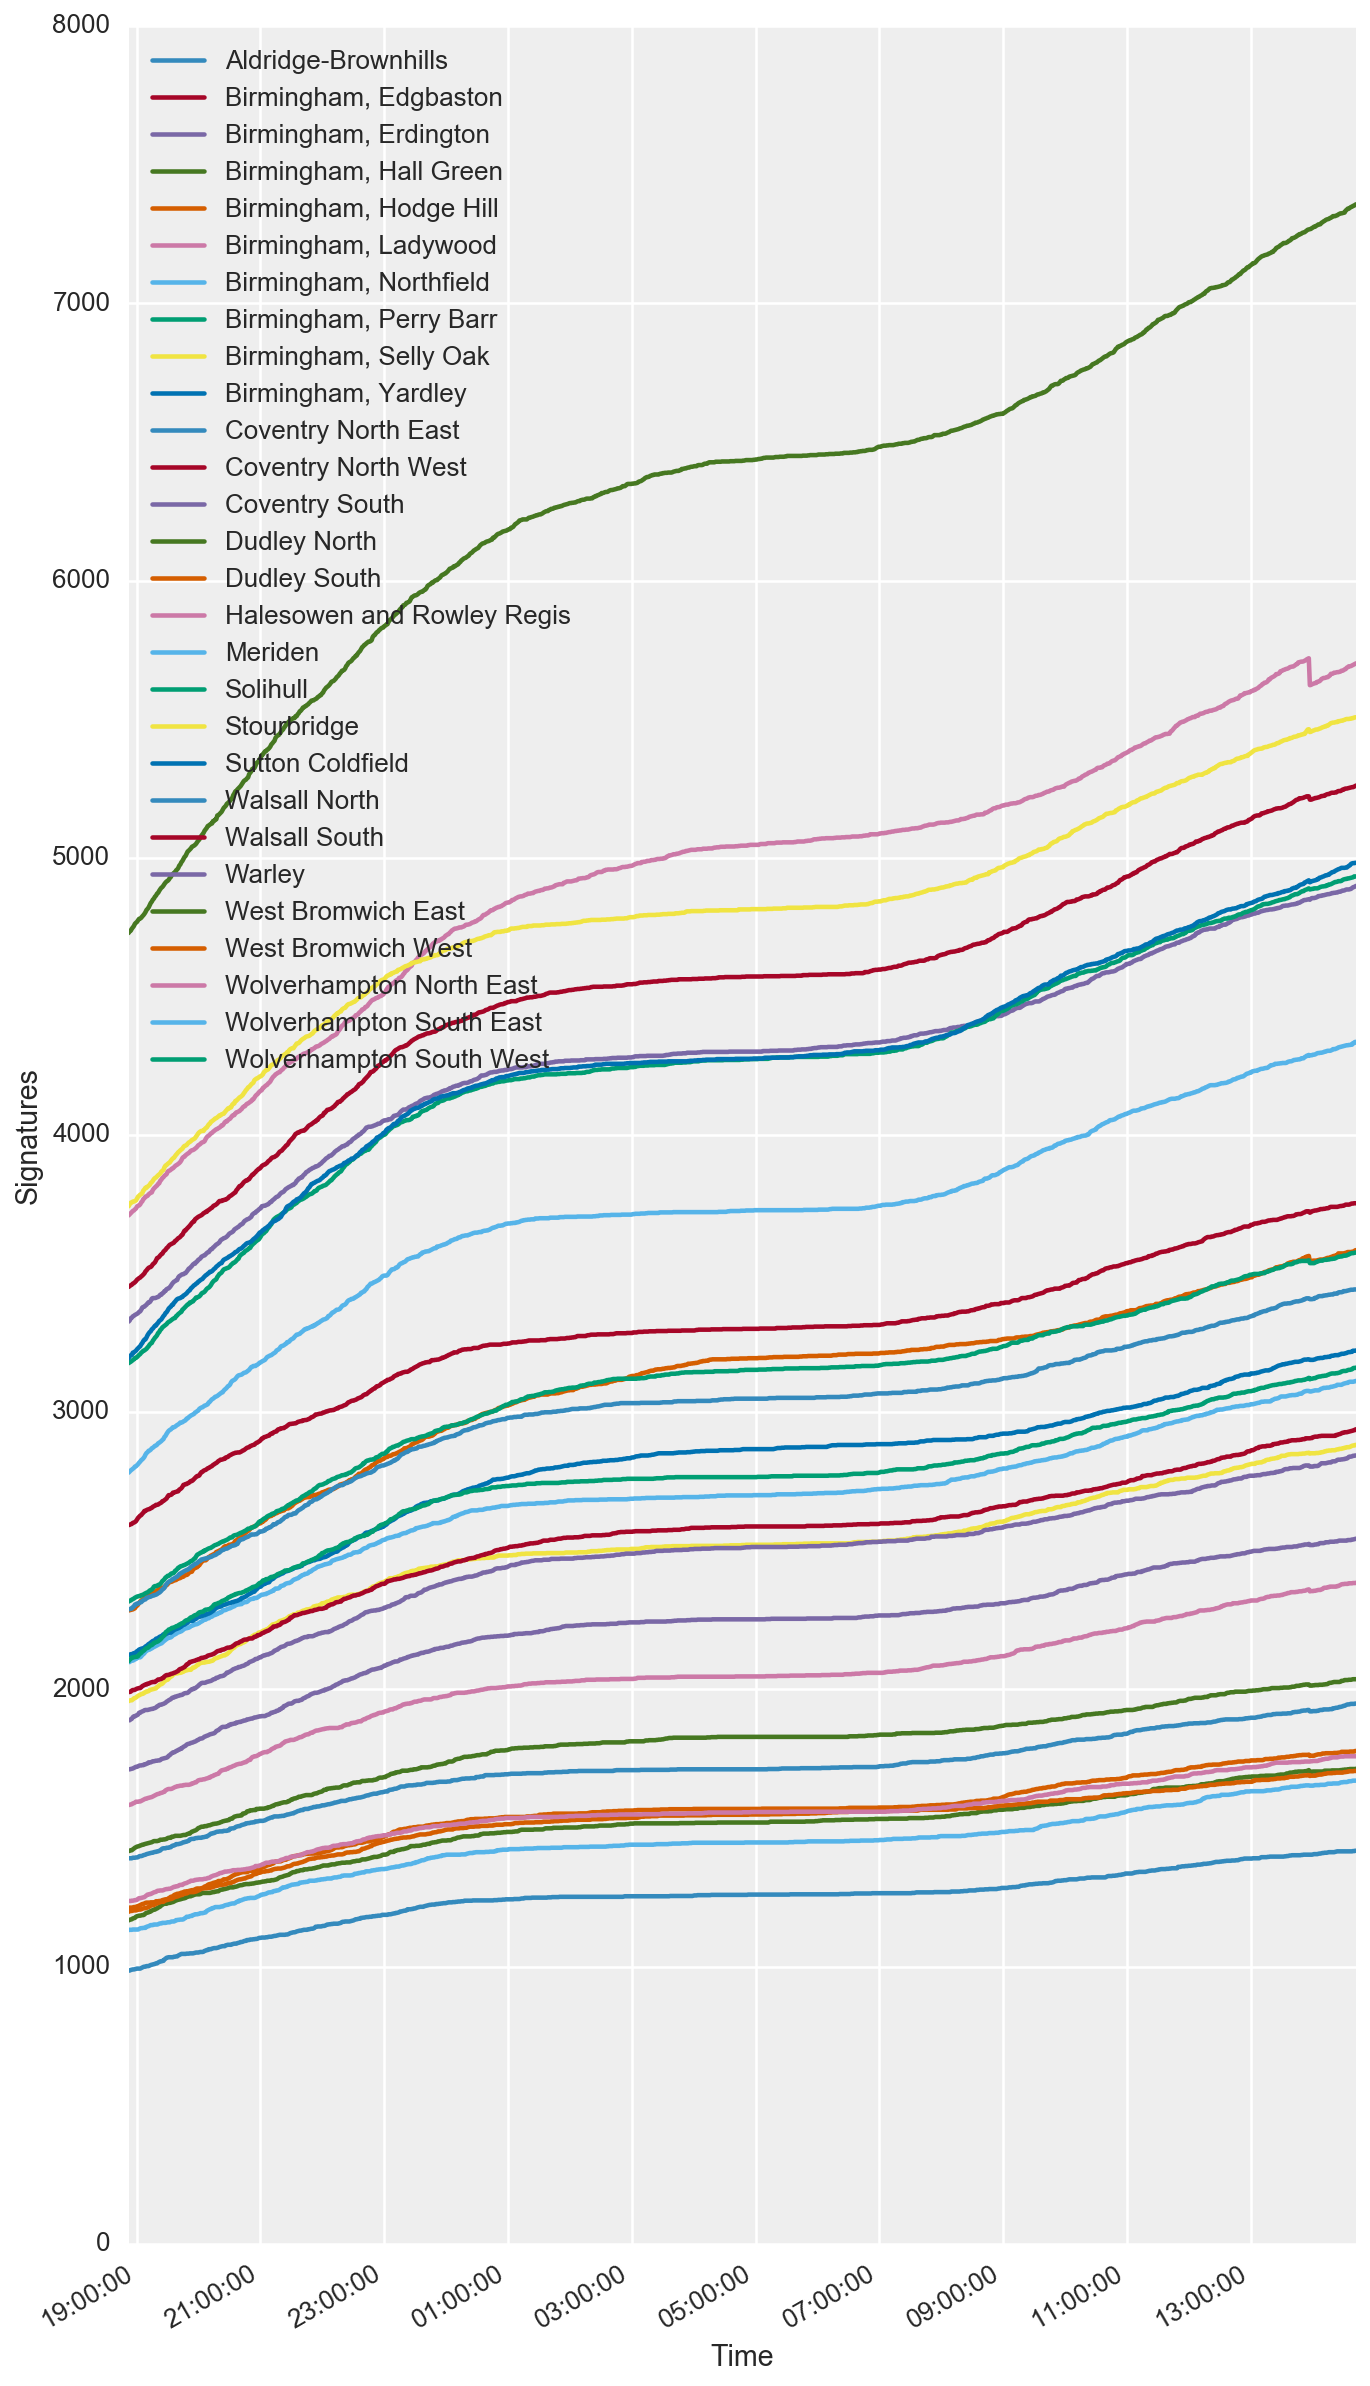

In [34]:
plot_group(wm, subplots_kw={'figsize': (11, 22)})

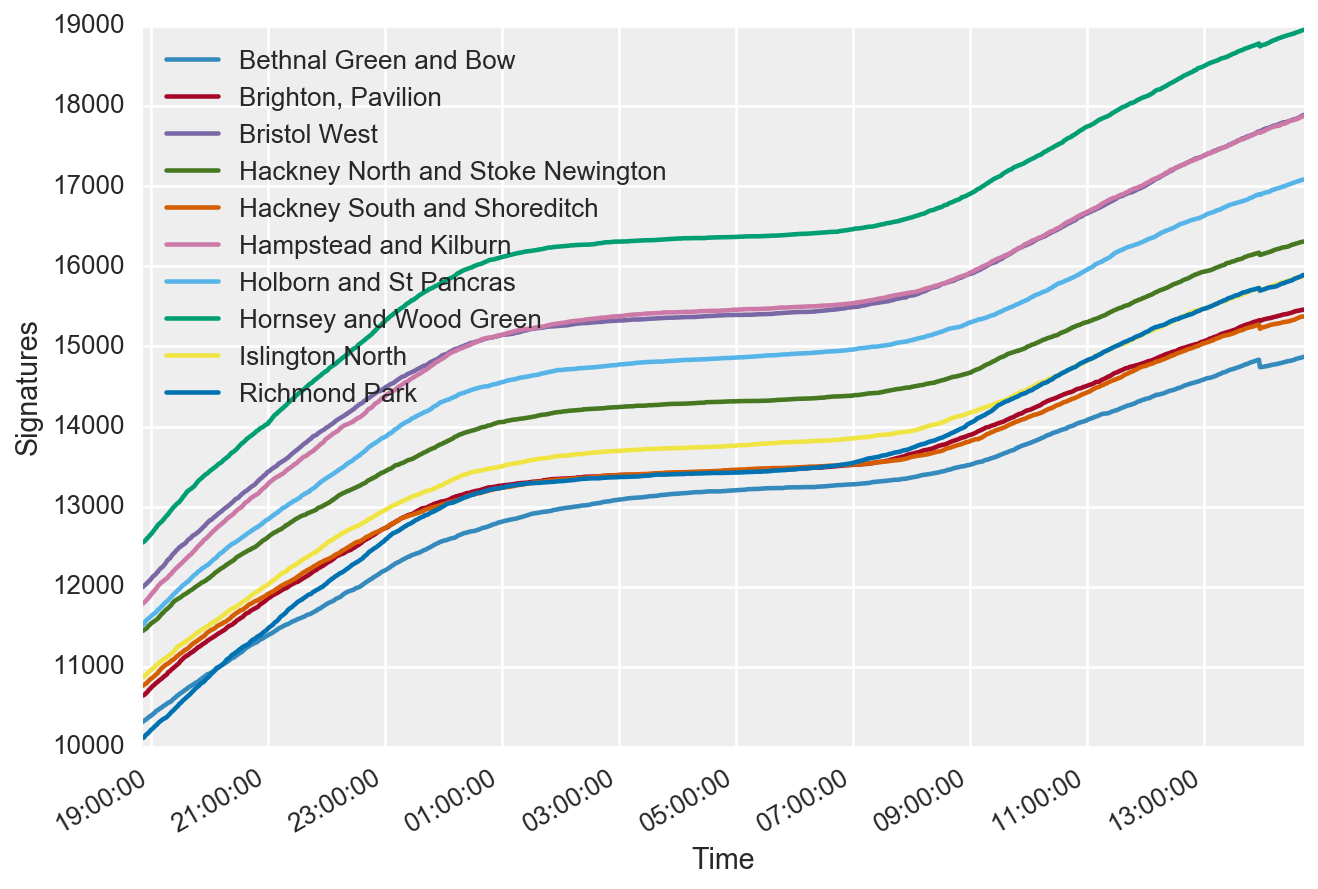

In [13]:
plot_group(highest_10)

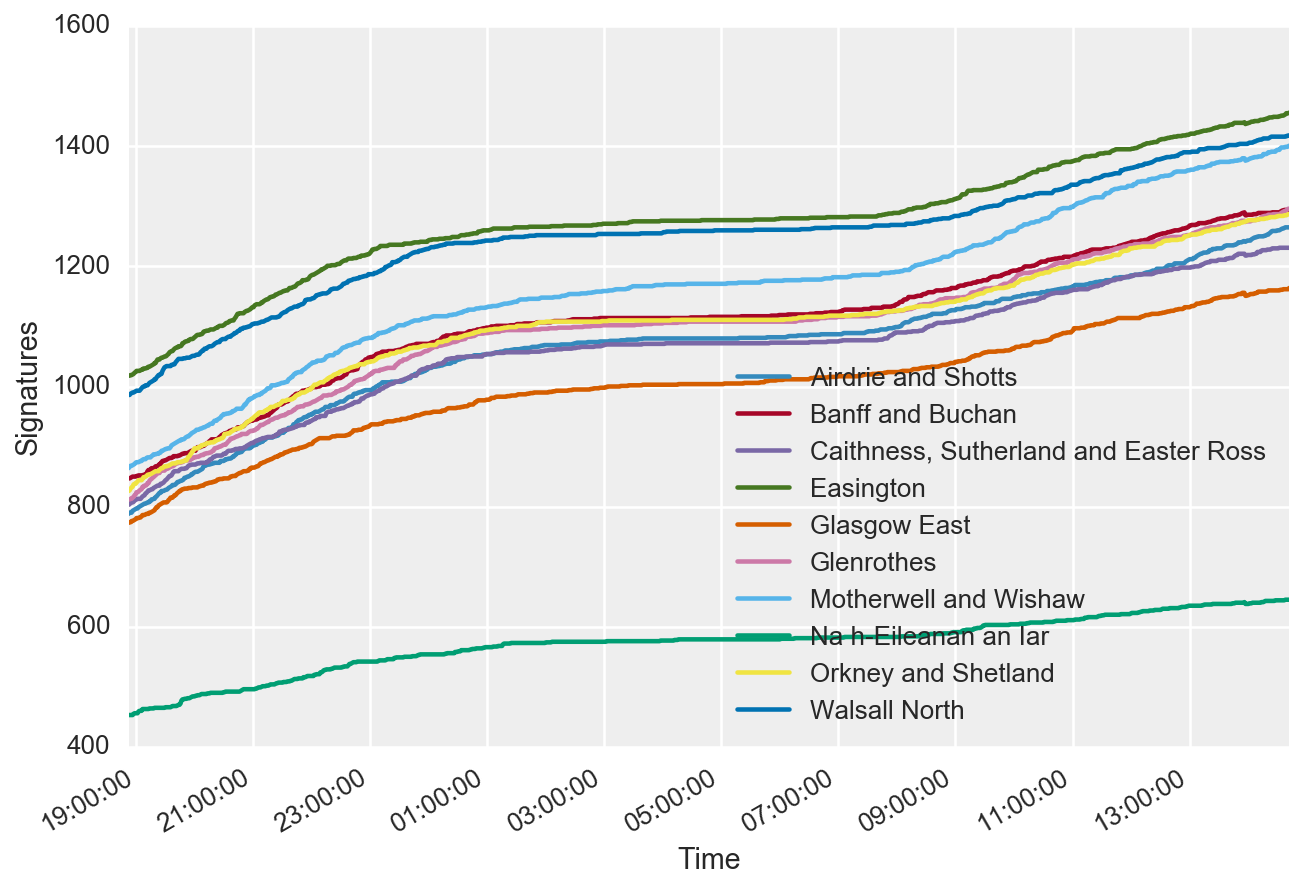

In [14]:
plot_group(lowest_10)